In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

DATASET_PATH = "VGGFace2_balanced_900_albumentations"
"""
Hi, this value can be changed according to the model used Okeee, so don't tell me that i didn't warn you
if you found out that your model doesn't work properly, Bye :)
"""
IMG_SIZE = 224 
BATCH_SIZE = 32

In [2]:
# each celebrity images' are inside a folder with that celibrity's name 
celebs = [celebrity for celebrity in os.listdir(DATASET_PATH) 
          if os.path.isdir(os.path.join(DATASET_PATH, celebrity))]
# Filter only the first 20 celebrities
celebs = celebs[:20]
print(f"Using {len(celebs)} classes:", celebs)
#creates IDs for each celebrity
label_map = {celebrity: id for id, celebrity in enumerate(celebs)}

Using 15 classes: ['Aditi Rao Hydari', 'Adrienne Bailon-Houghton', 'Alberto Núñez Feijóo', 'Aleksander Kwaśniewski', 'Aleksandra Kwaśniewska', 'Alesha Dixon', 'Alex Salmond', 'Alexa Chung', 'Alfredo Pérez Rubalcaba', 'Aléxis Tsípras', 'Amber Heard', 'Amy Adams', 'Andie MacDowell', 'Boris Tadić', 'Bronisław Komorowski']


In [3]:
# remove corrupted images
for celebrity in celebs:
    celebrity_path = os.path.join(DATASET_PATH, celebrity)
    for img_name in os.listdir(celebrity_path):
        img_path = os.path.join(celebrity_path, img_name)
        try:
            img = Image.open(img_path)
            img.verify()
        except:
            print("Removing corrupted:", img_path)
            os.remove(img_path)

In [3]:
# build dataset arrays, one for image paths => "lfw/Brad_Pitt/0001.jpg" and the other for storing labels => [0, 0, 1, ...]
image_paths = []
labels = []

for celebrity in celebs:
    celebrity_path = os.path.join(DATASET_PATH, celebrity)
    for img_name in os.listdir(celebrity_path):
        image_paths.append(os.path.join(celebrity_path, img_name))
        labels.append(label_map[celebrity])

# turn them into numpy
image_paths = np.array(image_paths)
labels = np.array(labels, dtype=np.int32)

In [4]:
# randomize images before splitting into train/val/test
indices = np.arange(len(image_paths))
np.random.seed(42)   # to get the same random shuffle every time you run the code
np.random.shuffle(indices)

image_paths = image_paths[indices]
labels = labels[indices]

In [5]:
# splitting into training (70%), validation (15%)& testing sets (15%)
train_end = int(0.7 * len(image_paths))
val_end   = int(0.85 * len(image_paths))

train_paths = image_paths[:train_end]
val_paths   = image_paths[train_end:val_end]
test_paths  = image_paths[val_end:]

train_labels = labels[:train_end]
val_labels   = labels[train_end:val_end]
test_labels  = labels[val_end:]

In [6]:
# data augmentation for only training set
# `p` means is the percentage/chance of applying to each image
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),    # flip image horizontally, 50% probability
    A.Rotate(limit=20, p=0.5),  # rotate ±20 degrees, 50% probability
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),    # for different lighting conditions
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),    # for face positioning variations
    A.GaussianBlur(blur_limit=3, p=0.2),    # for motion blur, out-of-focus images
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.3),    #for color variations
])


c:\Users\roaam\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
# load image and preprocess because neural networks work with fixed-size tensors only
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0    # normalize to [0..1]
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    return image, label


In [8]:
# use Albumentations inside a TensorFlow pipeline.
def augment_np(image, label):
    # convert float32 0..1 → uint8
    image = (image * 255.0).numpy().astype("uint8")

    aug = train_transform(image=image)["image"]

    # convert back to float32 0..1
    aug = aug.astype("float32") / 255.0

    return aug, label

def tf_augment(image, label):
    image, label = tf.py_function(
        func=augment_np,
        inp=[image, label],
        Tout=(tf.float32, tf.int32)
    )
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    label.set_shape(())
    return image, label

In [9]:
# normalization depending on the type of the model
def model_normalize(image, label, model_type="resnet"):
    if model_type in ["resnet", "mobilenet", "vit"]:
        # ImageNet mean/std
        mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
        std  = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
        image = (image - mean) / std

    elif model_type == "inception_v3" or model_type == "inception_v1":
        image = (image - 0.5) * 2.0  # [-1, 1]

    elif model_type == "none":  # VGG-19 from scratch
        pass  # keep 0..1

    return image, label

In [10]:
# creating preproccessed dataset
def create_dataset(paths, labels, model_type='resnet', augment=False, shuffle=True):

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    # load & scale (0..1)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # augment only training
    if augment:
        ds = ds.map(tf_augment, num_parallel_calls=tf.data.AUTOTUNE)

    # then apply model normalization
    ds = ds.map(lambda x, y: model_normalize(x, y, model_type),
                num_parallel_calls=tf.data.AUTOTUNE)

    # shuffle → batch → prefetch
    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return ds

In [11]:
"""
TEST CREATING DATASET FOR MODELS, SO FOLLOW THIS SAME SCHEMA PLEASE, IF YOU WANT TO CHANGE
THE MODEL YOU CAN ONLY CHANGE THE `model_type` VALUE OKEEE?
  VGG => none
  ResNet => resnet
  inception => inception_v3 or inception_v1 
  MobileNet => mobilenet
  ViT => vit
"""
train_dataset = create_dataset(train_paths, train_labels, model_type="mobilenet", augment=False)
val_dataset   = create_dataset(val_paths,   val_labels,   model_type="mobilenet", augment=False, shuffle=False)
test_dataset  = create_dataset(test_paths,  test_labels,  model_type="mobilenet", augment=False, shuffle=False)


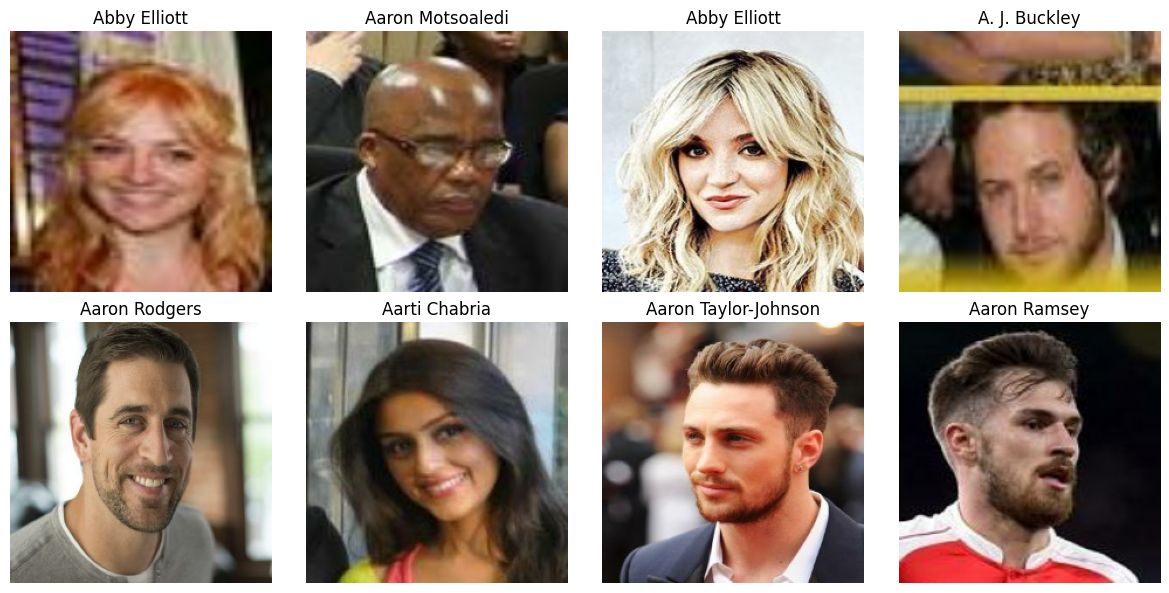

In [18]:
# testing image plot, at the beggining when i tested it the images were all reddish TwT but thank god i could fix it :)
def plot_batch(dataset, label_map, n=6):
    images, labels = next(iter(dataset))

    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n//2, i+1)

        # Reverse any model normalization for display
        img = images[i].numpy()

        # If image is normalized for ImageNet (ResNet, ViT, MobileNet)
        if img.min() < 0:
            mean = np.array([0.485, 0.456, 0.406])
            std  = np.array([0.229, 0.224, 0.225])
            img = img * std + mean   # undo normalize

        # If image in [-1, 1] (Inception)
        if img.min() < -0.1:
            img = (img + 1) / 2.0

        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(list(label_map.keys())[labels[i].numpy()])
        plt.axis("off")

    plt.tight_layout()
    plt.show()
plot_batch(train_dataset, label_map, n=8)

In [16]:
# test the pipeline
for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Image range: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
    print(f"Labels: {labels[:5].numpy()}")

Batch shape: (32, 224, 224, 3)
Image range: [-2.118, 2.640]
Labels: [18  8  7  0 15]


In [12]:
num_classes = len(celebs)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # freeze for transfer learning

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 7s 1us/step


In [13]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

test_loss, test_acc = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.1951 - loss: 2.3807 - val_accuracy: 0.3822 - val_loss: 1.9058
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.3436 - loss: 1.8957 - val_accuracy: 0.5151 - val_loss: 1.5705
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.4402 - loss: 1.6387 - val_accuracy: 0.5743 - val_loss: 1.4033
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.4905 - loss: 1.4790 - val_accuracy: 0.6064 - val_loss: 1.2780
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.5437 - loss: 1.3430 - val_accuracy: 0.6301 - val_loss: 1.1895
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.5853 - loss: 1.2386 - val_accuracy: 0.6390 - val_loss: 1.1197
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.6112 - loss: 1.1659 - val_accuracy: 0.6652 - val_loss: 1.0628
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.6346 - loss: 1.0913 - val_accu

In [ ]:

# -----------------------------
# Build the model
# -----------------------------
num_classes = len(celebs)

# Load pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze base for initial training
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # monitor validation loss
    patience=3,              # wait 3 epochs before stopping
    restore_best_weights=True,
    verbose=1
)

# -----------------------------
# Train top layers first
# -----------------------------
print("=== Training top layers only ===")
history_top = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stop]
)

# -----------------------------
# Fine-tune last layers of backbone
# -----------------------------
print("=== Fine-tuning last 20 layers of MobileNet ===")
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,               # max epochs; early stopping may terminate sooner
    callbacks=[early_stop]
)

# -----------------------------
# Evaluate on test dataset
# -----------------------------
test_loss, test_acc = model.evaluate(test_dataset)
print("Final Test Accuracy:", test_acc)


=== Training top layers only ===
Epoch 1/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.2049 - loss: 2.3564 - val_accuracy: 0.4193 - val_loss: 1.8657
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.3509 - loss: 1.8815 - val_accuracy: 0.5165 - val_loss: 1.5562
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.4422 - loss: 1.6351 - val_accuracy: 0.5798 - val_loss: 1.3953
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.4934 - loss: 1.4625 - val_accuracy: 0.6064 - val_loss: 1.2647
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.5471 - loss: 1.3383 - val_accuracy: 0.6123 - val_loss: 1.1928
Restoring model weights from the end of the best epoch: 5.
=== Fine-tuning last 20 layers of MobileNet ===
Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.4675 - loss: 1.6039 - val_accuracy: 0.6247 - val_loss: 1.0887
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.5874 - loss: 1.2567 - va

In [15]:
# Predict probabilities for test set
y_pred_probs = model.predict(test_dataset)  # shape: (num_samples, num_classes)

# Convert probabilities to predicted class indices
y_pred = y_pred_probs.argmax(axis=1)

# True labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

64/64 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report (Precision, Recall, F1-score per class)
report = classification_report(y_true, y_pred, target_names=celebs)
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

                          precision    recall  f1-score   support

        Aditi Rao Hydari       0.79      0.83      0.81       126
Adrienne Bailon-Houghton       0.80      0.79      0.79       135
    Alberto Núñez Feijóo       0.85      0.89      0.87       130
  Aleksander Kwaśniewski       0.89      0.89      0.89       149
  Aleksandra Kwaśniewska       0.75      0.83      0.78       138
            Alesha Dixon       0.82      0.80      0.81       133
            Alex Salmond       0.91      0.94      0.93       134
             Alexa Chung       0.89      0.83      0.86       139
 Alfredo Pérez Rubalcaba       0.97      0.98      0.97       144
          Aléxis Tsípras       0.91      0.95      0.93       128
             Amber Heard       0.84      0.77      0.80       116
               Amy Adams       0.81      0.83      0.82       127
         Andie MacDowell       0.87      0.80      0.83       160
             Boris Tadić       0.92      0.90      0.91       122
    Broni

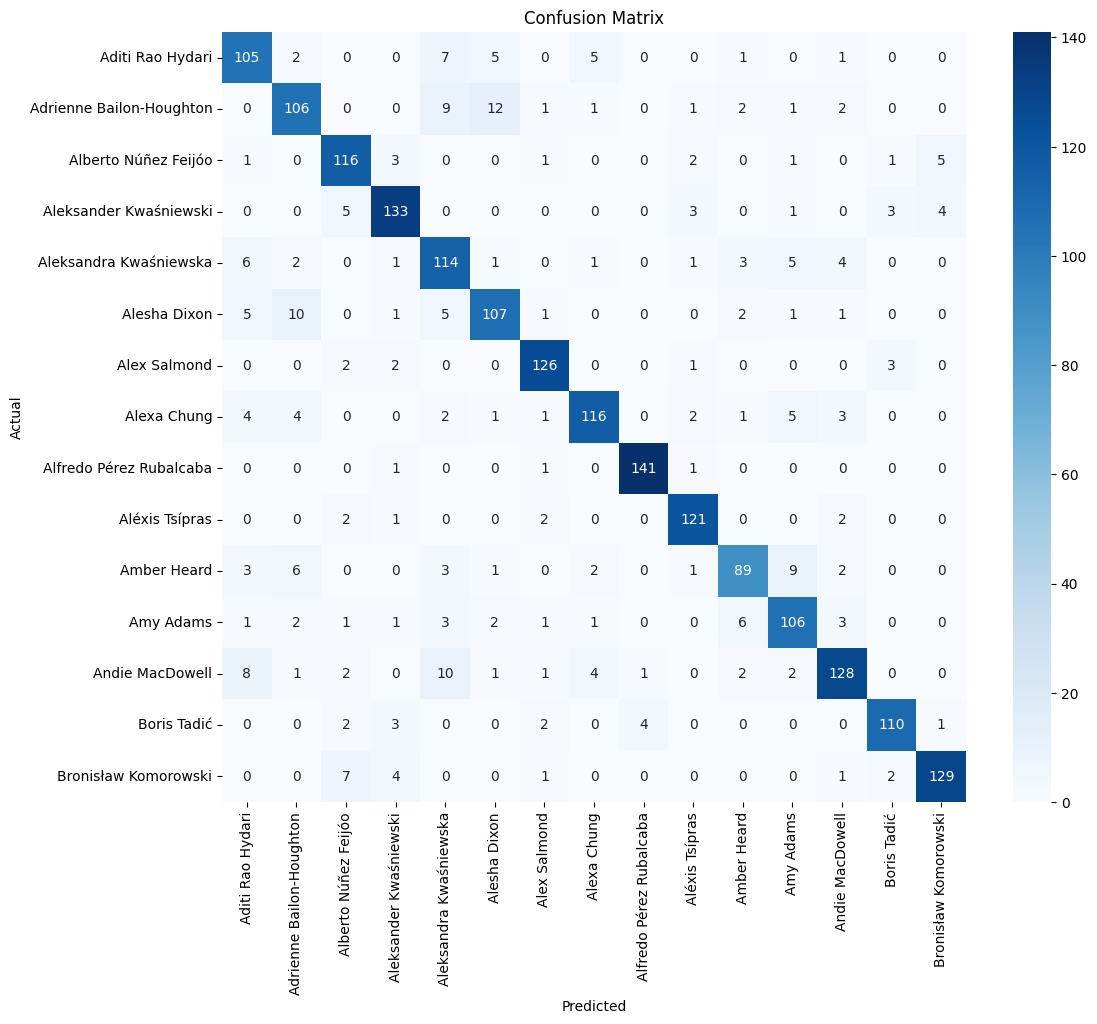

In [23]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=celebs, yticklabels=celebs)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

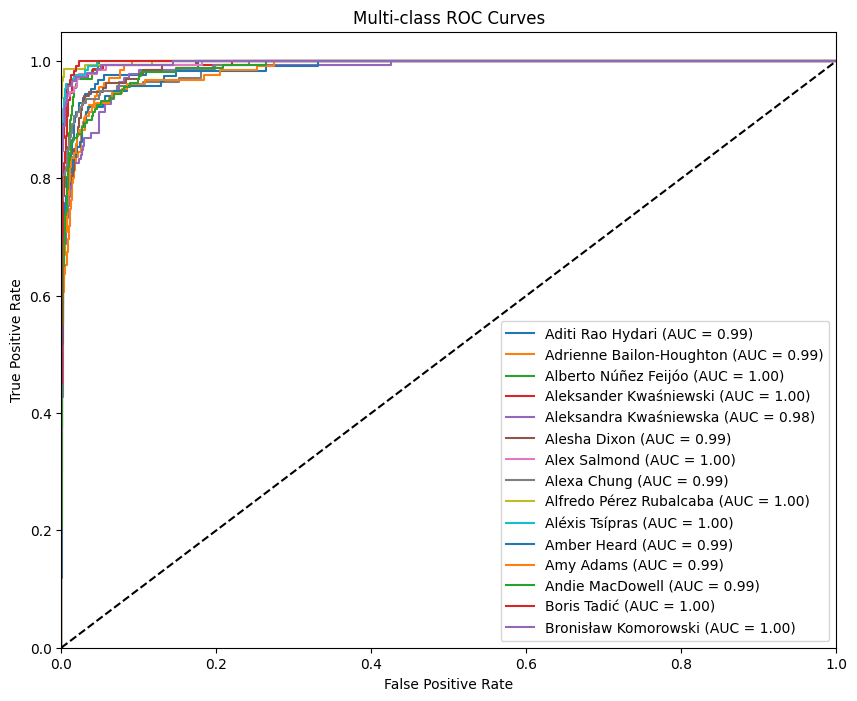

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# One-hot encode labels
y_true_onehot = label_binarize(y_true, classes=np.arange(len(celebs)))

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i, celeb in enumerate(celebs):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{celeb} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc="lower right")
plt.show()